# Detect Ads in radio stream using the trained models:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.cluster import MiniBatchKMeans
import joblib
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.callbacks import ModelCheckpoint
from DataGenerator import DataGenerator_Sup
from utility_functions import create_model, create_CNN_model, audio2features_vectors, listen_to, moving_average

Using TensorFlow backend.


Get a list of all files:

In [2]:
Radio_stream_folder = '../Data/radio_streams/' # audio files location

example_files = []
for r,d,f in os.walk(Radio_stream_folder):
    for filename in f:
        if '.mp3' in filename:
            example_files.append(os.path.join(r,filename))

How many mp3 files do we have?

In [3]:
n_files = len(example_files)

print('We have ' + str(n_files) + ' radio streaming examples')

We have 7 radio streaming examples


### Choose audio file and load it:

In [4]:
n = 5 # file number to load
d = 3 # duration in sec of a sigle clip


In [5]:
example_files[n]

'../Data/radio_streams/cool_101_7_snip_3.mp3'

In [6]:
X = audio2features_vectors(example_files[n])
print(X.shape)
print('file lenght is ' + str(X.shape[0]*d/60.0) + ' minutes')

(400, 1690)
file lenght is 20.0 minutes


Listen to the audio:

In [ ]:
# listen_to(example_files[n], 8.25, 9.5)

### Run model on file and extract start and end time:

In [7]:
# choose model's weights
weights_path = 'models/weights_1690_256_64_1.hdf5'

# recreate a model for evaluation
eval_model = create_model()
# load weights
eval_model.load_weights(weights_path)
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               432896    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 449,409
Trainable params: 449,409
Non-trainable params: 0
_________________________________________________________________


In [8]:
Ad_prob = eval_model.predict(X)
Ad_prob_avg = moving_average(Ad_prob)
t = np.arange(len(Ad_prob))*d/60.0 # create time axis
t_avg = moving_average(t)

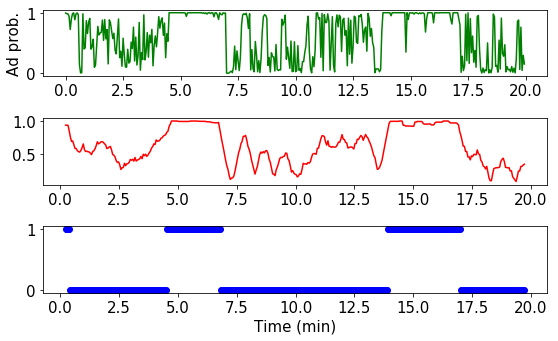

In [9]:
# %matplotlib notebook
T = 0.8

plt.rcParams.update({'font.size': 15})
plt.figure(figsize= (8,5))
plt.subplot(3,1,1)
plt.plot(t, Ad_prob, 'g')
plt.ylabel('Ad prob.')

plt.subplot(3,1,2)
plt.plot(t_avg, Ad_prob_avg, 'r')

plt.subplot(3,1,3)
plt.plot(t_avg, Ad_prob_avg>T, 'bo')
plt.xlabel('Time (min)')
plt.tight_layout()

In [ ]:
listen_to(example_files[n], 13.7, 17.2)

### Compare with another model:

In [10]:
# choose model's weights
weights_path = 'models/weights_1690_256_64_1_1000minutes_only_music_and_ads.hdf5'

# recreate a model for evaluation
eval_model = create_model()
# load weights
eval_model.load_weights(weights_path)
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               432896    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 449,409
Trainable params: 449,409
Non-trainable params: 0
_________________________________________________________________


In [11]:
Ad_prob = eval_model.predict(X)
Ad_prob_avg = moving_average(Ad_prob)
t = np.arange(len(Ad_prob))*d/60.0 # create time axis
t_avg = moving_average(t)

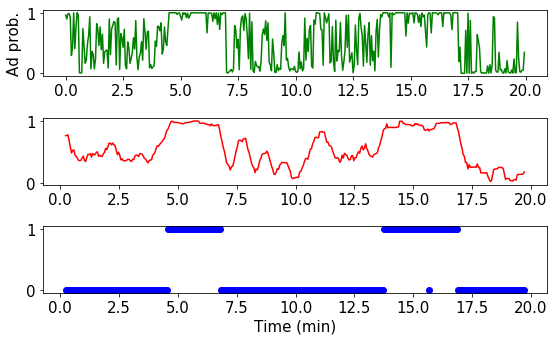

In [12]:
T = 0.85

plt.rcParams.update({'font.size': 15})
plt.figure(figsize= (8,5))
plt.subplot(3,1,1)
plt.plot(t, Ad_prob, 'g')
plt.ylabel('Ad prob.')

plt.subplot(3,1,2)
plt.plot(t_avg, Ad_prob_avg, 'r')

plt.subplot(3,1,3)
plt.plot(t_avg, Ad_prob_avg>T, 'bo')
plt.xlabel('Time (min)')
plt.tight_layout()

### Compare to CNN model:

In [13]:
X_cnn = audio2features_vectors(example_files[n], CNN= True)
print(X_cnn.shape)
print('file lenght is ' + str(X.shape[0]*d/60.0) + ' minutes')

(400, 13, 130, 1)
file lenght is 20.0 minutes


In [14]:
# choose model's weights
weights_path = 'models/weights_LeNet5ish_1000_only_music_and_ads.hdf5'

# recreate a model for evaluation
eval_model = create_CNN_model()
# load weights
eval_model.load_weights(weights_path)
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 130, 16)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 130, 16)       2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 27040)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                865312    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 867,825
Trainable params: 867,825
Non-trainable params: 0
_________________________________________________________________


In [15]:
Ad_prob_cnn = eval_model.predict(X_cnn)
Ad_prob_avg_cnn = moving_average(Ad_prob_cnn)
t = np.arange(len(Ad_prob_cnn))*d/60.0 # create time axis
t_avg = moving_average(t)

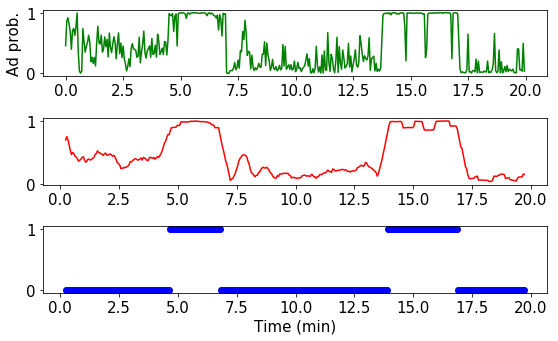

In [16]:
T = 0.8

plt.rcParams.update({'font.size': 15})
plt.figure(figsize= (8,5))
plt.subplot(3,1,1)
plt.plot(t, Ad_prob_cnn, 'g')
plt.ylabel('Ad prob.')

plt.subplot(3,1,2)
plt.plot(t_avg, Ad_prob_avg_cnn, 'r')

plt.subplot(3,1,3)
plt.plot(t_avg, Ad_prob_avg_cnn>T, 'bo')
plt.xlabel('Time (min)')
plt.tight_layout()

In [17]:
def extract_timestamps(Ad_prob, T=0.8, d=3):
    '''Takes an Ad probability vector, a threshold and time bin size
       and returns start and end timestamps'''
    # smoothing and creating a time axis
    Ad_prob_smooth = moving_average(Ad_prob) # smoothing 
    t = np.arange(len(Ad_prob))*d/60.0 # create time axis
    t_smooth = moving_average(t)
    
    # thresholding for detection and extracting start and end times
    detection_domains = (Ad_prob_smooth>T).astype(int) # get 1s for every detection
    transitions = np.diff(detection_domains) # get transitions between ads and non ads
    
    start_times = t_smooth[:-1][transitions == 1] # ad starts when prob. goes 0 -> 1
    end_times = t_smooth[:-1][transitions == -1] # ad ends when prob. goes 1 -> 0
    
    return np.array([start_times, end_times]).transpose()

In [18]:
result = extract_timestamps(Ad_prob_avg_cnn)
print(result)

[[ 4.375  6.475]
 [13.675 16.625]]


In [19]:
k = 0
listen_to(example_files[n], result[k][0], result[k][1])